1. Install Necessary Libraries

In [2]:
!pip install lightgbm

2. Import Libraries

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


3. Load and Explore Dataset

In [8]:
# Load the dataset
df = pd.read_csv('diabetes_prediction_dataset.csv')

# Display the first few rows
print(df.head())

# Dataset shape
print(f"Dataset Shape: {df.shape}")

# Target variable distribution
print(df['diabetes'].value_counts())

# Dataset information
df.info()

# Check for missing values
print("Missing Values:\n", df.isnull().sum())


   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  
Dataset Shape: (100000, 9)
diabetes
0    91500
1     8500
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               -------------- 

4. Data Cleaning

a. Handle smoking_history

In [12]:
# Standardize smoking history categories
df.replace({'ever': 'never', 'not current': 'former'}, inplace=True)

# Remove rows with 'No Info'
df = df[df['smoking_history'] != 'No Info']

# Verify updated counts
print(df['smoking_history'].value_counts())


smoking_history
never      39099
former     15799
current     9286
Name: count, dtype: int64


b. Handle gender

In [15]:
# Check gender distribution
print(df['gender'].value_counts())

# Remove rows with 'Other' and convert to numerical values
df = df[df['gender'] != 'Other']
df.replace({'Female': 0, 'Male': 1}, inplace=True)


gender
Female    38852
Male      25320
Other        12
Name: count, dtype: int64


C:\Users\Kruthik\AppData\Local\Temp\ipykernel_18356\1856693036.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'Female': 0, 'Male': 1}, inplace=True)


c. One-Hot Encoding for Categorical Variables

In [18]:
# Convert smoking_history to dummy variables
df = pd.get_dummies(df, columns=['smoking_history'], prefix='smoking_history').astype(int)

# Verify updated dataset
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 64172 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   gender                   64172 non-null  int32
 1   age                      64172 non-null  int32
 2   hypertension             64172 non-null  int32
 3   heart_disease            64172 non-null  int32
 4   bmi                      64172 non-null  int32
 5   HbA1c_level              64172 non-null  int32
 6   blood_glucose_level      64172 non-null  int32
 7   diabetes                 64172 non-null  int32
 8   smoking_history_current  64172 non-null  int32
 9   smoking_history_former   64172 non-null  int32
 10  smoking_history_never    64172 non-null  int32
dtypes: int32(11)
memory usage: 3.2 MB


5. Exploratory Data Analysis (EDA)

a. Correlation Heatmap

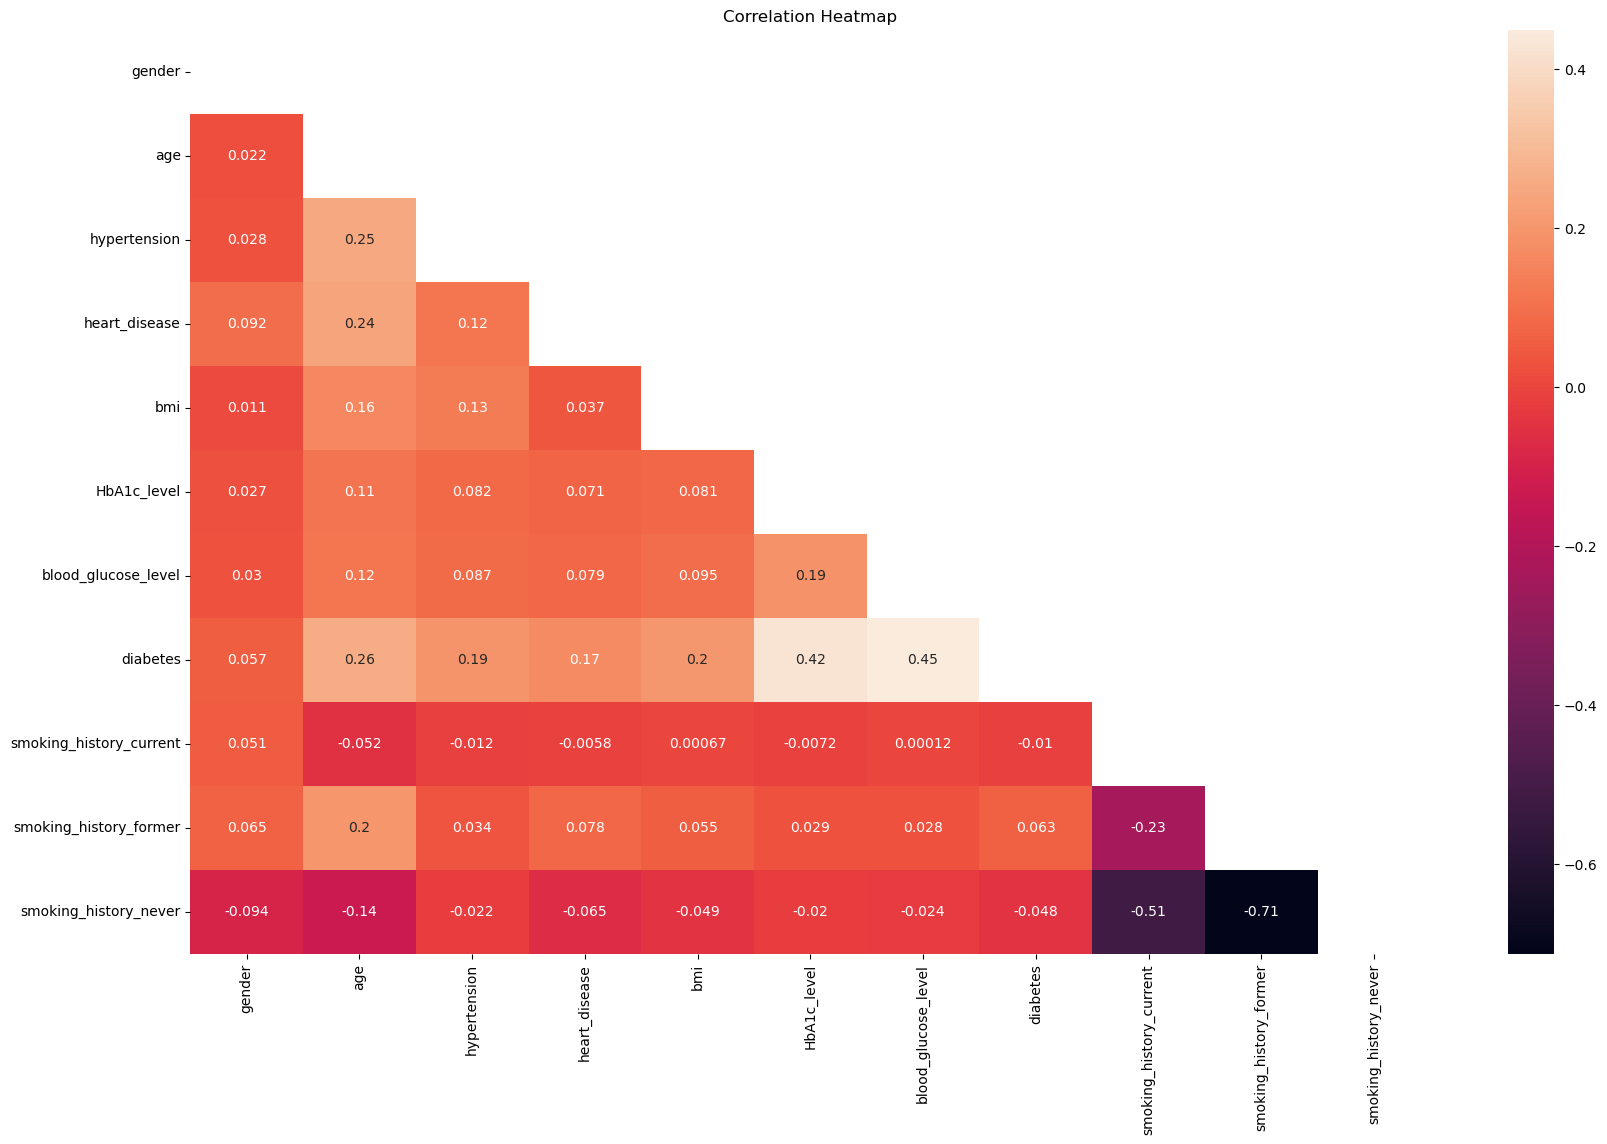

In [22]:
plt.figure(figsize=(20, 12))
corr = df.corr()
sns.heatmap(corr, annot=True, mask=np.triu(np.ones_like(corr, dtype=bool)))
plt.title("Correlation Heatmap")
plt.show()


b. Visualize Distributions

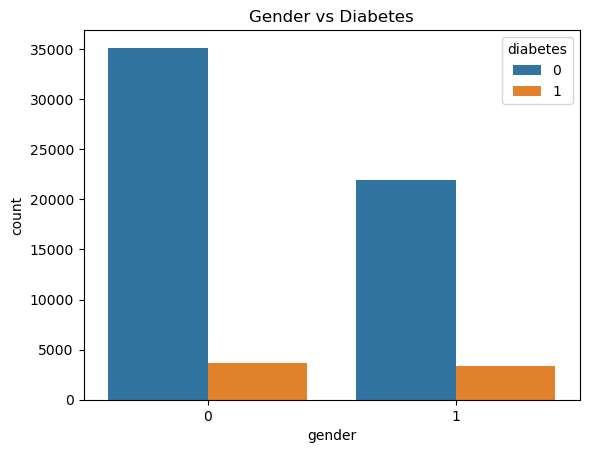

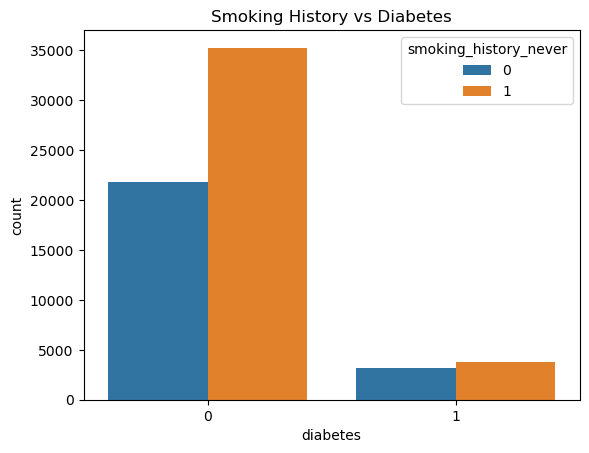

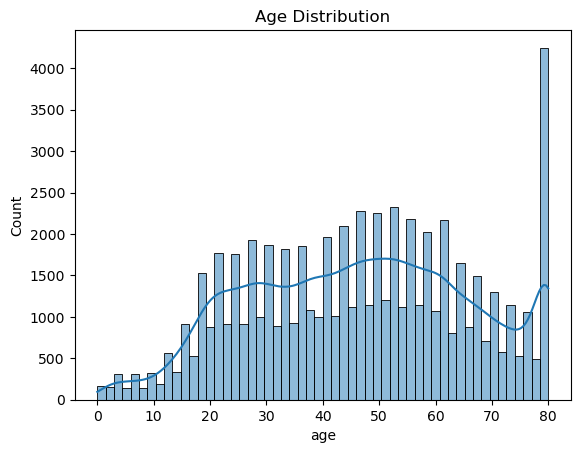

In [25]:
# Distribution of diabetes based on gender
sns.countplot(data=df, x='gender', hue='diabetes')
plt.title("Gender vs Diabetes")
plt.show()

# Distribution of smoking history and diabetes
sns.countplot(data=df, x='diabetes', hue='smoking_history_never')
plt.title("Smoking History vs Diabetes")
plt.show()

# Age distribution
sns.histplot(df['age'], kde=True)
plt.title("Age Distribution")
plt.show()


6. Handle Imbalances in the Dataset
python
Copy
Edit


In [30]:
# Separate classes
df_0_class = df[df['diabetes'] == 0]
df_1_class = df[df['diabetes'] == 1]

# Balance classes by sampling
df_0_sample = df_0_class.sample(n=df_1_class.shape[0], random_state=42)
balanced_df = pd.concat([df_0_sample, df_1_class]).sample(frac=1, random_state=42).reset_index(drop=True)

# Verify balanced classes
print(balanced_df['diabetes'].value_counts())


diabetes
1    7046
0    7046
Name: count, dtype: int64


7. Handle Outliers

a. For bmi

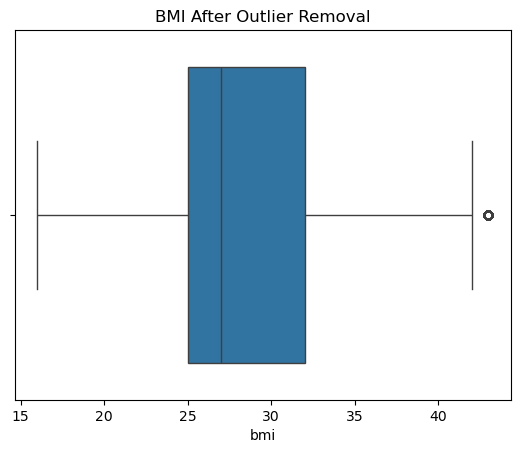

In [33]:
Q1 = balanced_df['bmi'].quantile(0.25)
Q3 = balanced_df['bmi'].quantile(0.75)
IQR = Q3 - Q1

# Outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
balanced_df = balanced_df[(balanced_df['bmi'] >= lower_bound) & (balanced_df['bmi'] <= upper_bound)]
sns.boxplot(x=balanced_df['bmi'])
plt.title("BMI After Outlier Removal")
plt.show()


b. For HbA1c_level

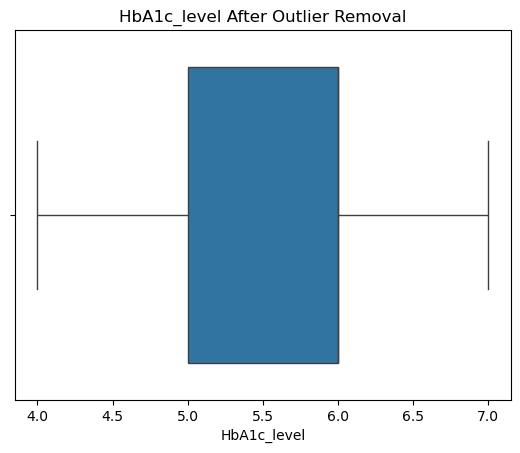

In [37]:
Q1 = balanced_df['HbA1c_level'].quantile(0.25)
Q3 = balanced_df['HbA1c_level'].quantile(0.75)
IQR = Q3 - Q1

# Outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
balanced_df = balanced_df[(balanced_df['HbA1c_level'] >= lower_bound) & (balanced_df['HbA1c_level'] <= upper_bound)]
sns.boxplot(x=balanced_df['HbA1c_level'])
plt.title("HbA1c_level After Outlier Removal")
plt.show()


8. Split the Dataset
python
Copy
Edit


In [40]:
# Separate features and target
X = balanced_df.drop('diabetes', axis=1)
y = balanced_df['diabetes']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


9. Feature Scaling

In [43]:
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


10. Model Training

In [46]:
# Initialize and train model
model = LGBMClassifier()
model.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 3759, number of negative: 4589
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 152
[LightGBM] [Info] Number of data points in the train set: 8348, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.450287 -> initscore=-0.199509
[LightGBM] [Info] Start training from score -0.199509


LGBMClassifier()

11. Model Evaluation

Accuracy: 87.89%
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.88      0.89      1574
           1       0.85      0.88      0.86      1209

    accuracy                           0.88      2783
   macro avg       0.88      0.88      0.88      2783
weighted avg       0.88      0.88      0.88      2783



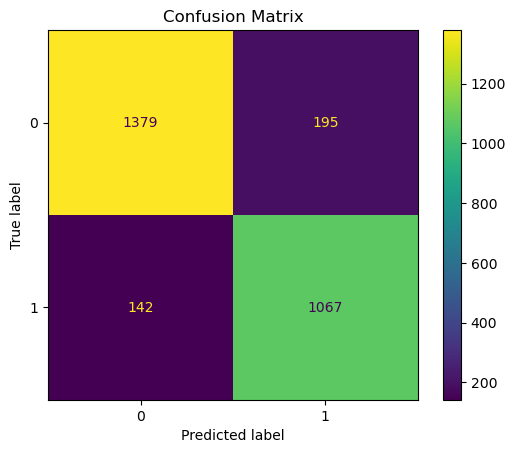

In [49]:
# Make predictions
y_pred = model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Confusion Matrix")
plt.show()
